# Simple Exponential Smoothing (SES) 

### Load required packages.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd 
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import acf
from dmba import regressionSummary
import warnings 

import matplotlib.pylab as plt
%matplotlib inline

no display found. Using non-interactive Agg backend


### Create template for graph layout.

In [13]:
# Create a template for graph layout with entire dataset and 12 periods 
# into future. 
def Graph_Layout_Entire_Data():
    # Determine coordinates for drawing vertical lines and horizontal 
    # arrows on the chart.
    one_month = pd.Timedelta('31 days')
    xridership = (min(ridership_ts.index), max(ridership_ts.index) - one_month)
    xfuture = (max(ridership_ts.index) + one_month, '2022')
    xvf = xridership[1] + 1.0 * (xfuture[0] - xridership[1])

    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2018-12', 3300), xytext=('1991', 3300), 
              arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2021-12', 3300), xytext=('2019-2', 3300), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('2005', 3330, 'Training')
    ax.text('2019-7', 3330, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2022')
    ax.set_ylim(1300, 3500)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')

### Create measures of forecast accuracy.

In [3]:
# Create forcast accuracy measures.
def Forecast_Accuracy(actual, forecast):
    
    # ME - mean error
    me = round(np.mean(actual - forecast),3) 
    
    # RMSE - root mean square error (RMSE)
    rmse = round((np.mean((actual - forecast)**2)**.5),3)  
   
    # MAE - mean absolute error
    mae = round(np.mean(np.abs(actual - forecast)),3)   
   
    # MPE - mean percentage error,%
    mpe = round(((np.mean((actual - forecast)/actual))*100),3) 
    
    # MAPE - mean absolute percentage error, %
    mape = round(((np.mean(np.abs((actual - forecast)/actual)))*100),3) 
    
    # Ignore unnecessary future warnings on ACF1. 
    warnings.filterwarnings('ignore')
   
    # ACF1 - autocorrelation of errors at lag 1
    acf1 = round((acf(actual - forecast)[1]),3)                 
    
    return({'ME':me, 'RMSE':rmse, 'MAE':mae, 
            'MPE':mpe, 'MAPE':mape, 'ACF1':acf1})

### Create time series data set.

In [4]:
# Create Amtrak data frame.
Amtrak_data = pd.read_csv('Amtrak_comp.csv')

# Display the first 5 records of Amtrak data set.

# Convert the date information to a datetime object as monthly data.
Amtrak_data['Date'] = pd.to_datetime(Amtrak_data.Month)

# Convert data set to time series  data set. Name is used 
# to label the data.
ridership_ts = pd.Series(Amtrak_data.Ridership.values, 
                index=Amtrak_data.Date, name='Ridership')

# Define Amtrak time series frequency as month 'MS'. 
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq = 'MS')

# Display first 5 records of Amtrak time series data.
ridership_ts.head()

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
Freq: MS, Name: Ridership, dtype: float64

### Simple exponential smoothing (SES) with original data, alpha = 0.2.

In [5]:
# Create simple exponential smoothing (SES) for Amtrak data with alpha = 0.2.

# Use SimpleExpSmoothing()function with alpha = 0.2 (no trend 
# and no seasonality) to fit SES over the original data.
# Apply initialization_method='estimated' to avoid a warning 
# about the initialization at model creation. 
ses_orig = SimpleExpSmoothing(ridership_ts, 
           initialization_method='estimated').fit(smoothing_level=0.2, optimized=False)

# Show the SES parameters.
print('SES Parameters')
print (ses_orig.params)

# Print SES fitted values for ridership_ts.
print(' ')
print('Fitted SES Values')
print(ses_orig.fittedvalues)

# Use forecast() function to make predictions using this SES model with alpha = 0.2 
# and 12 periods into the future. Show predictions in tabular format.
ses_orig_pred = round(ses_orig.forecast(12), 3)
print(' ')
print('SES Forecast for 12 Periods into Future')
print(ses_orig_pred)

SES Parameters
{'smoothing_level': 0.2, 'smoothing_trend': None, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 1807.681399999999, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
 
Fitted SES Values
Date
1991-01-01    1807.681400
1991-02-01    1787.928520
1991-03-01    1754.460016
1991-04-01    1798.111013
1991-05-01    1800.821810
                 ...     
2018-08-01    2689.567301
2018-09-01    2721.440841
2018-10-01    2681.626073
2018-11-01    2706.740858
2018-12-01    2740.186287
Freq: MS, Length: 336, dtype: float64
 
SES Forecast for 12 Periods into Future
2019-01-01    2725.759
2019-02-01    2725.759
2019-03-01    2725.759
2019-04-01    2725.759
2019-05-01    2725.759
2019-06-01    2725.759
2019-07-01    2725.759
2019-08-01    2725.759
2019-09-01    2725.759
2019-10-01    2725.759
2019-11-01    2725.759
2019-12-01    2725.759
Freq: MS, dtype: float64


### Simple exponential smoothing (SES) with original data and optimal alpha.

In [6]:
# Create simple exponential smoothing (SES) for Amtrak data with optimal alpha.

# Use SimpleExpSmoothing()function with optimal alpha (no alpha, no trend, 
# and no seasonality) to fit SES over the original data (no specific
# parameters defined in the fit() function).
ses_opt = SimpleExpSmoothing(ridership_ts, 
          initialization_method='estimated').fit()

# Show the SES parameters.
print('SES Parameters')
print (ses_opt.params)

# Print SES fitted values for ridership_ts.
print(' ')
print('Fitted SES Values')
print(ses_opt.fittedvalues)

# Use forecast() function to make predictions using this SES model with optimal alpha
# and 12 periods into the future. Show predictions in tabular format.
ses_opt_pred = round(ses_opt.forecast(12), 3)
print(' ')
print('SES Forecast for 12 Periods into Future')
print(ses_opt_pred)


SES Parameters
{'smoothing_level': 0.5406046782232176, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 1732.3415571720284, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
 
Fitted SES Values
Date
1991-01-01    1732.341557
1991-02-01    1719.678132
1991-03-01    1666.108462
1991-04-01    1831.861391
1991-05-01    1820.943127
                 ...     
2018-08-01    2829.219134
2018-09-01    2839.877623
2018-10-01    2668.229895
2018-11-01    2743.357784
2018-12-01    2813.966278
Freq: MS, Length: 336, dtype: float64
 
SES Forecast for 12 Periods into Future
2019-01-01    2735.083
2019-02-01    2735.083
2019-03-01    2735.083
2019-04-01    2735.083
2019-05-01    2735.083
2019-06-01    2735.083
2019-07-01    2735.083
2019-08-01    2735.083
2019-09-01    2735.083
2019-10-01    2735.083
2019-11-01    2735.083
2019-12-01    2735.083
Freq: MS, dtype: float64


### Plot original data and SES forecast: original and optimal.

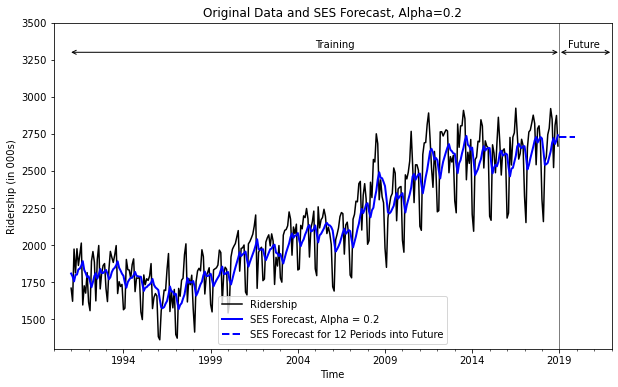

In [16]:
# Plot the original data and SES forecast for alpha=02.

# Plot ridership.ts data.
ax = ridership_ts.plot(color='black', linewidth=1.5, figsize=(10,6))

# Plot SES fitted data and SES forecast for original alpha = 0.2.
ses_orig.fittedvalues.plot(ax = ax, color="blue", linewidth=2)
ses_orig_pred.plot(ax = ax, color="blue", style='--', linewidth=2)

# Determine coordinates for drawing vertical lines and horizontal 
# arrows and on the chart.
Graph_Layout_Entire_Data()

# Create legend and title for the chart.
ax.legend(['Ridership', 'SES Forecast, Alpha = 0.2',  
           'SES Forecast for 12 Periods into Future'],
           loc = 'lower center')
plt.title('Original Data and SES Forecast, Alpha=0.2')

plt.show()

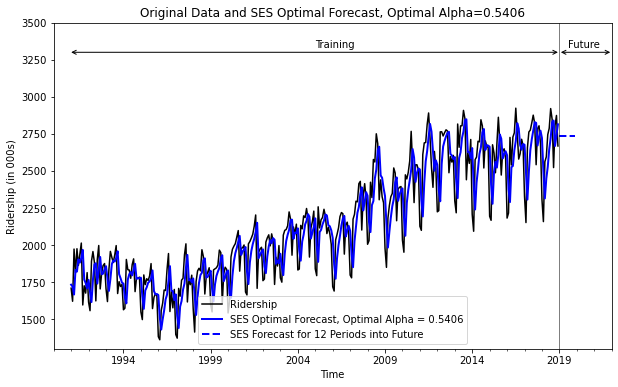

In [18]:
# Plot the original data and SES forecast for optimal alpha=0.1456.

# Plot ridership.ts data.
ax = ridership_ts.plot(color='black', linewidth=1.5, figsize=(10,6))
# valid_ts.plot(ax=ax, color='black', style='--', linewidth=1.5)

# Plot SES fitted data and SES forecast for optimal alpha = 0.1456.
ses_opt.fittedvalues.plot(ax = ax, color="blue", linewidth=2)
ses_opt_pred.plot(ax = ax, color="blue", style='--', linewidth=2)

# Determine coordinates for drawing vertical lines and horizontal 
# arrows and on the chart.
Graph_Layout_Entire_Data()

# Create legend and title for the chart.
ax.legend(['Ridership', 'SES Optimal Forecast, Optimal Alpha = 0.5406',  
           'SES Forecast for 12 Periods into Future'],
           loc = 'lower center' )
plt.title("Original Data and SES Optimal Forecast, Optimal Alpha=0.5406")

plt.show()

In [19]:
# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common 
# accuracy measures for SES model with alpha=0.2.
print('Accuracy Measures for SES Forecast, Alpha=0.2')
print(Forecast_Accuracy(ridership_ts, ses_orig.fittedvalues))

# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common 
# accuracy measures for SES optimal model with optimal alpha.
print(' ')
print('Accuracy Measures for SES Optimal Forecast, Optimal Alpha=0.5406')
print(Forecast_Accuracy(ridership_ts, ses_opt.fittedvalues))

Accuracy Measures for SES Forecast, Alpha=0.2
{'ME': 13.662, 'RMSE': 185.699, 'MAE': 154.574, 'MPE': -0.087, 'MAPE': 7.415, 'ACF1': 0.357}
 
Accuracy Measures for SES Optimal Forecast, Optimal Alpha=0.5406
{'ME': 5.52, 'RMSE': 183.986, 'MAE': 146.192, 'MPE': -0.313, 'MAPE': 7.039, 'ACF1': 0.14}
